## Data Study

In this file we have the analysis using the final dataset builted in **Prepare Data - NEW** file.

1. **[Importing libraries](#Importinglibraries)**
2. **[Dataset Loading](#DatasetLoading)**
    1. [General Info](#GeneralInfo)
    2. [Exploration](#Exploration)
3. **[Nkill](#NKILL)**
    1. [Features](#Features)
    2. [P-Value](#Pvalue)
    3. [Scaler](#Scaler)
    4. [Linear Regression](#LR)
    5. [Generalize Linear Regression](#GLR)

<a id="Importinglibraries"></a>
### Importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import asarray
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import *
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import isnan, when, count, col
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline
from pyspark.mllib.tree import RandomForest, RandomForestModel

Init Spark context

In [3]:
sc = pyspark.SparkContext(appName="Pi")

<a id="DatasetLoading"></a>
### Dataset Loading

Load the dataset

In [4]:
spark = SparkSession(sc)
ds = spark.read.csv("fin1shed_country.csv.gz", header=True, inferSchema=True)

<a id="GeneralInfo"></a>
**General Info**

**Rows:** 2045

**Columns:** 12

In [5]:
ds.show(5)

+-----+------------------+-------+-----+---------+------+-----------+-------------+--------+----------+-----+----------------------------+
|iyear|       country_txt|country|nkill|ransom_No|nwound|property_Ok|individual_No|Firearms|Explosives|Melee|GDP per capita (current US$)|
+-----+------------------+-------+-----+---------+------+-----------+-------------+--------+----------+-----+----------------------------+
| 1970|         Argentina|     11|  1.0|      1.0|   0.0|       0.75|          1.0|    0.75|       0.0|  0.0|            1317.48753519866|
| 1970|Dominican Republic|     58|  1.0|      1.0|   0.0|        0.0|          1.0|     0.0|       0.0|  0.0|            329.860647543011|
| 1970|           Germany|    362|  7.0|      1.0|   9.0|        1.0|          1.0|     0.0|       0.0|  0.0|            2750.71974235504|
| 1970|           Germany|    499|  0.0|      1.0|   0.0|        1.0|          1.0|     0.0|       1.0|  0.0|            2750.71974235504|
| 1970|    United Kingdom| 

In [6]:
print((ds.count(), len(ds.columns)))

(2045, 12)


In [7]:
ds.columns

['iyear',
 'country_txt',
 'country',
 'nkill',
 'ransom_No',
 'nwound',
 'property_Ok',
 'individual_No',
 'Firearms',
 'Explosives',
 'Melee',
 'GDP per capita (current US$)']

Let's remove the **Unnamed: 0** and **region_txt** columns. The first one because isn't usefull for the analisis and the second one because there is **region** that is the same only just converted in to number

In [8]:
ds1 = ds.drop(*['country_txt', '_c0','iyear','cnt', 'country', 'ransom_No', 'individual_No'])
print((ds1.count(), len(ds1.columns)))

(2045, 7)


There's no NaN

In [9]:
ds1.select([count(when(isnan(c), c)).alias(c) for c in ds1.columns]).show()

+-----+------+-----------+--------+----------+-----+----------------------------+
|nkill|nwound|property_Ok|Firearms|Explosives|Melee|GDP per capita (current US$)|
+-----+------+-----------+--------+----------+-----+----------------------------+
|    0|     0|          0|       0|         0|    0|                           0|
+-----+------+-----------+--------+----------+-----+----------------------------+



In [10]:
ds1.printSchema()

root
 |-- nkill: double (nullable = true)
 |-- nwound: double (nullable = true)
 |-- property_Ok: double (nullable = true)
 |-- Firearms: double (nullable = true)
 |-- Explosives: double (nullable = true)
 |-- Melee: double (nullable = true)
 |-- GDP per capita (current US$): double (nullable = true)



<a id="Exploration"></a>
**Exploration**

Let's see the distribution of the datas

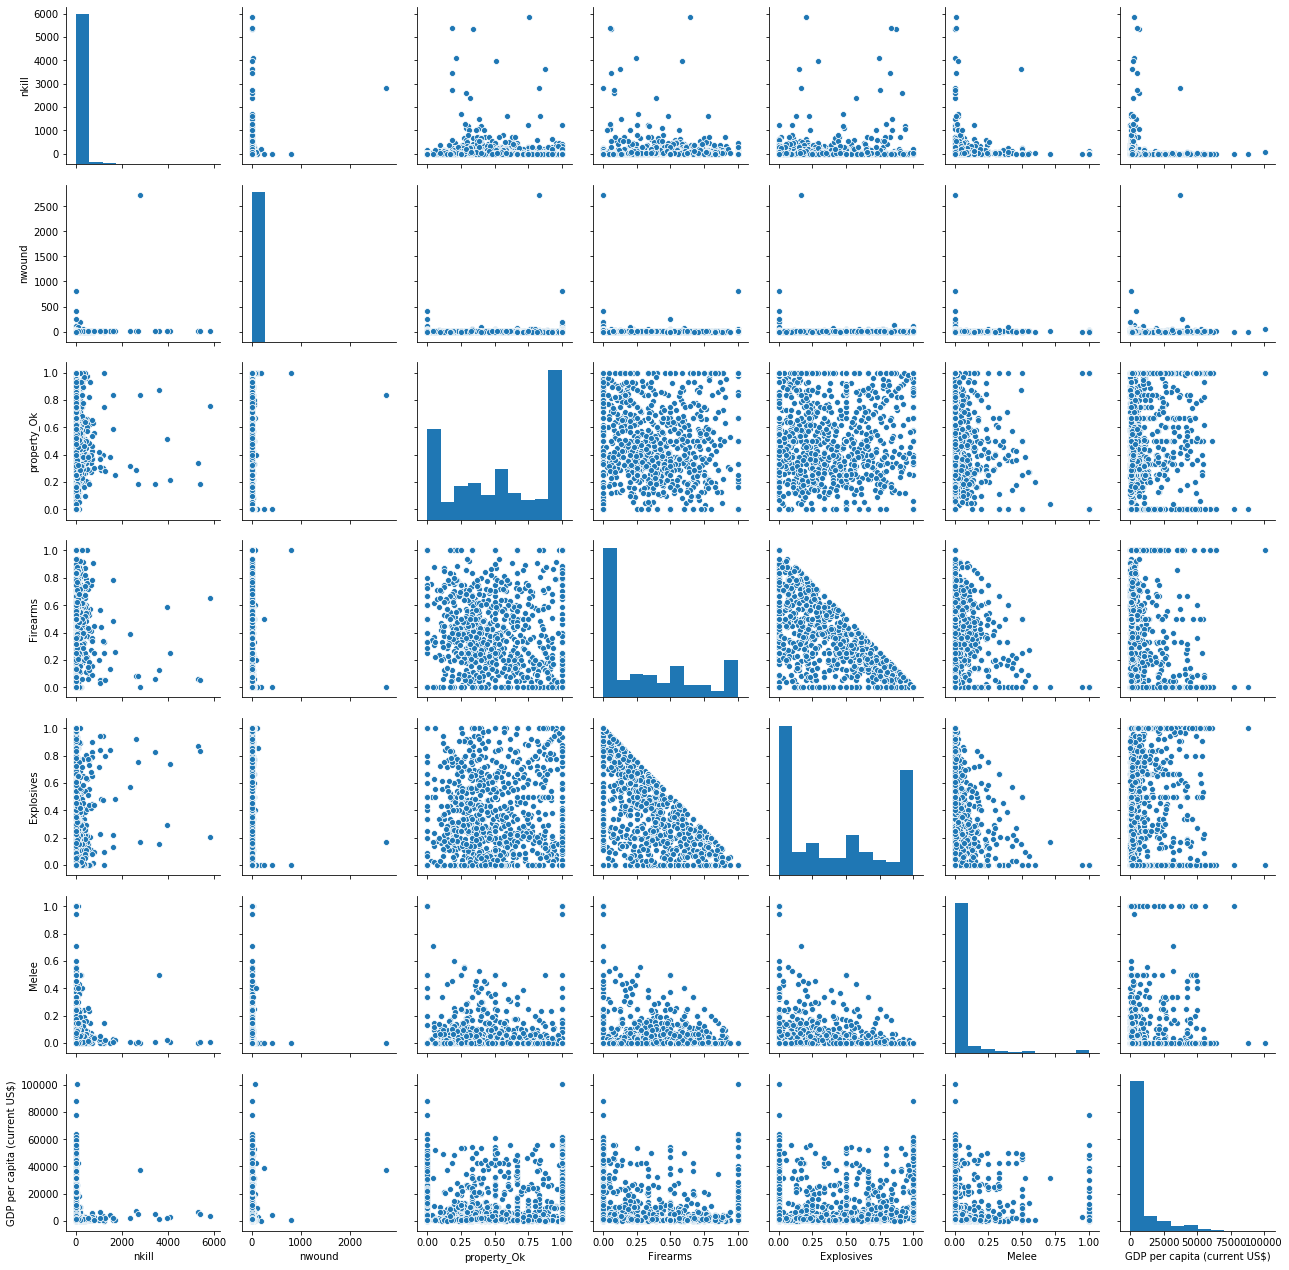

In [11]:
pdf = ds1.toPandas()
sns.pairplot(pdf, vars=pdf.columns)

In [12]:
ds1.describe().show(vertical=True)

-RECORD 0-------------------------------------------
 summary                      | count               
 nkill                        | 2045                
 nwound                       | 2045                
 property_Ok                  | 2045                
 Firearms                     | 2045                
 Explosives                   | 2045                
 Melee                        | 2045                
 GDP per capita (current US$) | 2045                
-RECORD 1-------------------------------------------
 summary                      | mean                
 nkill                        | 68.34914425427873   
 nwound                       | 5.7030114437441055  
 property_Ok                  | 0.5528316463259231  
 Firearms                     | 0.3051913566853853  
 Explosives                   | 0.4340381072190764  
 Melee                        | 0.04448894758450636 
 GDP per capita (current US$) | 7346.10661138346    
-RECORD 2-------------------------------------

Let's see the correlation of the datas.

it requires you to provide a column of type **Vector**. So we need to convert our columns into a vector column first using the **VectorAssembler** and then apply the correlation.

In [13]:
ds1.columns

['nkill',
 'nwound',
 'property_Ok',
 'Firearms',
 'Explosives',
 'Melee',
 'GDP per capita (current US$)']

In [14]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=ds1.columns, outputCol=vector_col)
df_vector = assembler.transform(ds1).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

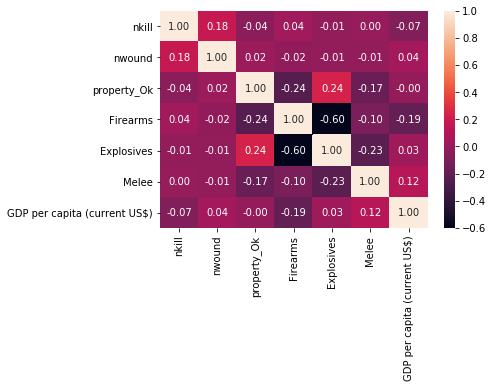

In [15]:
ax = sns.heatmap(corrmatrix, xticklabels=ds1.columns, yticklabels=ds1.columns, annot=True, fmt=".2f")


In [16]:
vif = pd.DataFrame()
pdf = pdf.drop(columns="nkill")
vif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]
vif["features"] = pdf.columns
vif

,VIF Factor,features
0,1.010280,nwound
1,2.556664,property_Ok
2,1.302401,Firearms
3,2.123831,Explosives
4,1.076493,Melee
5,1.312105,GDP per capita (current US$)


In [17]:
#vif = pd.DataFrame()
#pdf = pdf.drop(columns={"iyear", "region"})
#vif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]
#vif["features"] = pdf.columns
#vif

<a id="NKILL"></a>
## NKILL

In this section we use NKILL as response variable.

<a id="Features"></a>
**Features** 

we procede to build the feature column combining all the columns except the **nkill** column, that will be our response. To achieve this pourpose we use **VectorAssembler** and the result is called **features**

In [18]:
f_columns = ds1.select([c for c in ds1.columns if c not in {'nkill'}]).columns
len(f_columns)

6

In [19]:
assembler = VectorAssembler(inputCols=f_columns,outputCol="features")

In [20]:
feature = assembler.transform(ds1) 
feature.show(2, False, vertical= True)

-RECORD 0----------------------------------------------------------------
 nkill                        | 1.0                                      
 nwound                       | 0.0                                      
 property_Ok                  | 0.75                                     
 Firearms                     | 0.75                                     
 Explosives                   | 0.0                                      
 Melee                        | 0.0                                      
 GDP per capita (current US$) | 1317.48753519866                         
 features                     | [0.0,0.75,0.75,0.0,0.0,1317.48753519866] 
-RECORD 1----------------------------------------------------------------
 nkill                        | 1.0                                      
 nwound                       | 0.0                                      
 property_Ok                  | 0.0                                      
 Firearms                     | 0.0   

In [21]:
feature.select("features").show(10, False)

+----------------------------------------------------------------------------------------------------+
|features                                                                                            |
+----------------------------------------------------------------------------------------------------+
|[0.0,0.75,0.75,0.0,0.0,1317.48753519866]                                                            |
|(6,[5],[329.860647543011])                                                                          |
|[9.0,1.0,0.0,0.0,0.0,2750.71974235504]                                                              |
|[0.0,1.0,0.0,1.0,0.0,2750.71974235504]                                                              |
|(6,[2,5],[1.0,2347.54431773747])                                                                    |
|[0.29545454545454547,0.6818181818181818,0.18181818181818182,0.6363636363636364,0.0,5246.88371730098]|
|(6,[5],[567.410541860583])                                              

<a id="Pvalue"></a>
**P-Value** 

In [22]:
chisq = ChiSquareTest.test(feature,"features","nkill").head()
pvalue = pd.Series(chisq.pValues , index=f_columns)
print("P-Value:\n",pvalue )

P-Value:
 nwound                          0.0
property_Ok                     0.0
Firearms                        0.0
Explosives                      0.0
Melee                           0.0
GDP per capita (current US$)    1.0
dtype: float64


In [23]:
f_columns = ds1.select([c for c in ds1.columns if c not in {'nkill', "country"}]).columns
len(f_columns)

6

In [24]:
assembler = VectorAssembler(inputCols=f_columns,outputCol="features")

In [25]:
feature = assembler.transform(ds1) 
feature.show(2, False, vertical= True)

-RECORD 0----------------------------------------------------------------
 nkill                        | 1.0                                      
 nwound                       | 0.0                                      
 property_Ok                  | 0.75                                     
 Firearms                     | 0.75                                     
 Explosives                   | 0.0                                      
 Melee                        | 0.0                                      
 GDP per capita (current US$) | 1317.48753519866                         
 features                     | [0.0,0.75,0.75,0.0,0.0,1317.48753519866] 
-RECORD 1----------------------------------------------------------------
 nkill                        | 1.0                                      
 nwound                       | 0.0                                      
 property_Ok                  | 0.0                                      
 Firearms                     | 0.0   

<a id="Scaler"></a>
**Scaler** 

In [26]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scalerModel = scaler.fit(feature)
scaledData = scalerModel.transform(feature)
scaledData.show(2, vertical= True)

-RECORD 0--------------------------------------------
 nkill                        | 1.0                  
 nwound                       | 0.0                  
 property_Ok                  | 0.75                 
 Firearms                     | 0.75                 
 Explosives                   | 0.0                  
 Melee                        | 0.0                  
 GDP per capita (current US$) | 1317.48753519866     
 features                     | [0.0,0.75,0.75,0.... 
 scaledFeatures               | [-0.0885190708980... 
-RECORD 1--------------------------------------------
 nkill                        | 1.0                  
 nwound                       | 0.0                  
 property_Ok                  | 0.0                  
 Firearms                     | 0.0                  
 Explosives                   | 0.0                  
 Melee                        | 0.0                  
 GDP per capita (current US$) | 329.860647543011     
 features                   

<a id="VIF1"></a>
**Variance Inflation Factor** 

In [27]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(ds1_scaled.values, i) for i in range(ds1_scaled.shape[1])]
#vif["features"] = ds1_scaled.columns
#vif

<a id="LR"></a>
**Linear Regression** 

Let's procede to build a model and evaluate them. The first step it's to build a model. We use a Linear regression and to evaluate the performance of the esmtimator we relied on the study of residuals, in particular way we use the R^2 indicator.

In [28]:
df_ready = scaledData.select([c for c in scaledData.columns if c in ["scaledFeatures", "nkill"]])
df_ready = scaledData.selectExpr("scaledFeatures as features", "nkill as label")

In [29]:
train, test = df_ready.randomSplit([0.8, 0.2], seed=12345)

In [30]:
lr = LinearRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [50]).addGrid(lr.elasticNetParam, [0,0.2,0.4,0.6,0.8]).addGrid(lr.regParam, [1e-4,1e-3,1e-2,1e-1]).build()
evaluator = RegressionEvaluator(metricName="r2")

In [31]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5, seed=33, parallelism=2)

In [32]:
cvModel = cv.fit(train)

In [33]:
bestModel = cvModel.bestModel.summary

In [34]:
print("MIGLIOR MODELLO: ")
model = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
for key, value in model.items() :
    print (key, value)
print("R^2: ", bestModel.r2adj)
print("ITERATION: ", bestModel.totalIterations)
print("MIGLIOR MODELLO TEST R^2: ", evaluator.evaluate(cvModel.transform(test)))


MIGLIOR MODELLO: 
LinearRegression_342862cb9792__maxIter 50
LinearRegression_342862cb9792__elasticNetParam 0.0
LinearRegression_342862cb9792__regParam 0.0001
R^2:  0.04439322450959149
ITERATION:  1
MIGLIOR MODELLO TEST R^2:  0.01483005062944065


In [35]:
coeff = cvModel.bestModel.coefficients
size = cvModel.bestModel.coefficients.size
labels = f_columns


In [36]:
pd.Series(coeff , index=f_columns)

nwound                          59.491125
property_Ok                    -12.102473
Firearms                        12.424579
Explosives                       7.536430
Melee                            0.544987
GDP per capita (current US$)   -23.282353
dtype: float64

<BarContainer object of 6 artists>

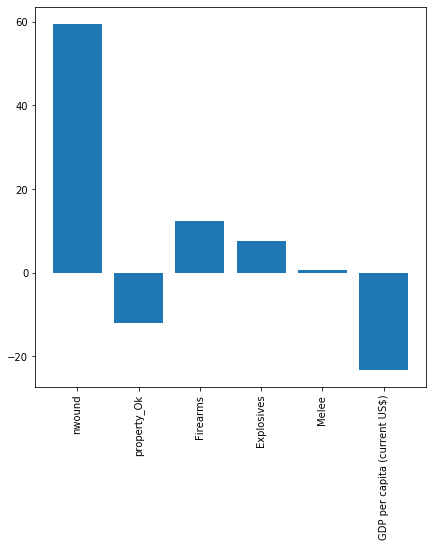

In [37]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_xticks(np.arange(size))
ax.set_xticklabels(labels, rotation=90)
plt.bar(np.arange(size), coeff)

<a id="GLR"></a>
**RANDOM FOREST** 

In [38]:
rf = RandomForestRegressor(featuresCol="features", labelCol='label', 
                           maxDepth=15, maxBins=120, impurity='variance', 
                           seed=12345, numTrees=250, featureSubsetStrategy='auto')

In [39]:
model = rf.fit(train)

In [40]:
predictions = model.transform(test)

In [41]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.2802747004730015

In [42]:
#model.toDebugString

**RF2**

Always stop the context.

In [43]:
#sc.stop()